In this notebook, we evaluate the gender and emotion word bias for AWS and Google sentiment APIs using  of the emotion words using the corpus defined in https://saifmohammad.com/WebPages/Biases-SA.html.
We use a paired Wilcoxon signed-rank test.

In [14]:
import pandas as pds
import numpy as np
from scipy.stats import wilcoxon, ttest_ind
import seaborn as sns
from mlxtend.evaluate import permutation_test

In [2]:
_AWS_GOOGLE_SCORE_DF_FILE = './data/complete_set_sentiment_scores.csv'
_AWS_GOOGLE_SCORE_UPDATED_FILE = './data/updated_complete_set_sentiment_scores.csv'

In [3]:
emotion_df = pds.read_csv(_AWS_GOOGLE_SCORE_DF_FILE)
updated_emotion_df = pds.read_csv(_AWS_GOOGLE_SCORE_UPDATED_FILE)

In [5]:
emotion_df[:2]

,idx,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word,goog_scores,aws_neg_scores,aws_pos_scores,aws_neu_scores,aws_mix_scores,aws_combined
0,0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry,0.0,0.881573,0.011329,0.095531,0.011568,-1
1,1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious,0.1,0.798154,0.028035,0.159113,0.014699,-1


In [6]:
len(emotion_df)

8640

In [7]:
def combine_aws_scores(df, suffix='x'):
    """AWS Comprehend sentiment API produces a probability that the sentiment is negative, neutral or positive."""
    cols = ['{}_{}'.format(cname, suffix) for cname in ['aws_neg_scores',  'aws_neu_scores', 'aws_pos_scores']]
    return np.sum(np.multiply(df[cols].values, np.array([-1.0,0.0,1.0])), axis=1)

In [8]:
_EMOTIONS = ['anger', 'sadness', 'joy', 'fear']

In [9]:
_MAIN_COLUMNS = ['ID', 'Template', 'Emotion word', 'Emotion', 'Sentence', ]
_MAIN_COLUMNS += ['aws_neg_scores','aws_pos_scores','aws_neu_scores', 'goog_scores']
_GENDER_COLUMNS = _MAIN_COLUMNS + ['Gender']
_RACE_COLUMNS = _MAIN_COLUMNS + ['Race']
_MAIN_WORDS = ['angry', 'sad', 'happy', 'scared']

In [10]:
from matplotlib import pylab as plt

In [11]:
def stars(p):
    if (p < 0.05):
        return "p < 0.05 !"
    else:
        return "No significant difference"

In [140]:
def create_sentiment_df(basis, df=emotion_df):
    """Calculate p-values for the racial pairings, and put in a uniform data frame."""
    deltas = []
    frames = []
    gframes = []
    fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True)
    merge_cols = ['Template', 'Emotion word', 'Emotion']
    cols = _RACE_COLUMNS if basis == 'Race' else _GENDER_COLUMNS
    affected_class = 'African-American' if basis == 'Race' else 'female'
    impacting_class = 'European' if basis == 'Race' else 'male'
    ac_probs_df = df[cols][df[basis] == affected_class]
    ic_probs_df = df[cols][df[basis] == impacting_class]
    probs_df = pds.merge(ac_probs_df, ic_probs_df, on=merge_cols, how='inner')
    probs_df = probs_df[probs_df['Emotion word'].notnull()]
    probs_df_filtered = probs_df.drop_duplicates(subset=['ID_x'], inplace=False, keep='first').drop_duplicates(subset=['ID_y'], inplace=False, keep='first')
    for idx, emotion in enumerate(_EMOTIONS):
        #ax = axes[idx]
        em = probs_df_filtered[(probs_df_filtered['Emotion'] == emotion)]
        em = em.sample(len(em), random_state=20)
        display_df = pds.DataFrame(index=range(0, 2*len(em)), )
        aa_scores = combine_aws_scores(em[em[f'{basis}_x'] == affected_class], 'x')
        print(f"Length of affected_class: {len(aa_scores)}")
        display_df.loc[:len(aa_scores)-1, 'AWS Score'] = aa_scores
        display_df.loc[:len(aa_scores)-1, basis] =  affected_class
        eu_scores = combine_aws_scores(em[em[f'{basis}_y'] == impacting_class], 'y')
        print(f"Length of impacting_class: {len(eu_scores)}")
        display_df.loc[len(aa_scores):, 'AWS Score'] = eu_scores
        display_df['AWS Score'] = display_df['AWS Score'].astype(float)
        display_df.loc[len(aa_scores):, basis] =  impacting_class
        display_df.loc[:, 'Emotion'] = emotion
        _, p = wilcoxon(aa_scores, eu_scores, )
        print('AWS emotion: {}, p-value (Wilcoxon) : {:.5f}'.format(emotion, p))
        _, p = ttest_ind(aa_scores, eu_scores, )
        print('AWS emotion: {}, p-value (T) : {:.5f}'.format(emotion, p))
        p = permutation_test(aa_scores, eu_scores, method="approximate", num_rounds=1000, seed=20)
        print('AWS emotion: {}, p-value (Perm) : {:.5f}'.format(emotion, p))
        delta = (aa_scores - eu_scores).mean()
        disparity = f'{affected_class}/{impacting_class}'
        deltas.append({'Emotion': emotion, 'Platform': 'AWS', 'p-value': p, 'Disparity': disparity, 'delta': delta})
        
        
        aa_scores = em[em[f'{basis}_x'] == affected_class]['goog_scores_x']
        display_df.loc[:len(aa_scores)-1, 'Google Score'] = aa_scores.values
        display_df.loc[:len(aa_scores)-1, basis] =  affected_class
        eu_scores = em[em[f'{basis}_y'] == impacting_class]['goog_scores_y']
        display_df.loc[len(aa_scores):, 'Google Score'] = eu_scores.values
        display_df['Google Score'] = display_df['Google Score'].astype(float)
        display_df.loc[len(aa_scores):, basis] =  impacting_class
        display_df.loc[:, 'Emotion'] = emotion
        _, p = wilcoxon(aa_scores, eu_scores, )
        print('Google emotion: {}, p-value (Wilcoxon) : {:.5f}'.format(emotion, p))
        delta = 0 if p > 0.05 else (aa_scores - eu_scores).mean()
        deltas.append({'Emotion': emotion, 'Platform': 'Google', 'p-value': p, 'Disparity': disparity, 'delta': delta})

        frames.append(display_df)
        
        # y_max = np.max(np.concatenate((aa_scores, eu_scores)))
        # y_min = np.min(np.concatenate((aa_scores, eu_scores)))
        #sns.boxplot(data=display_df, x='Race', y='Score', ax=ax)
        # print (y_max)
        #ax.annotate("", xy=(0, y_max), xycoords='data',
        #            xytext=(1, y_max), textcoords='data',
        #            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
        #                            connectionstyle="bar,fraction=0.2"))
        #ax.text(0, y_max + .3, stars(p),
        #        horizontalalignment='left',
        #        verticalalignment='center')
        #ax.set_xlabel(emotion, )
        #if idx == 0:
        #    ax.set_ylabel('Score', rotation=0,)
        #else:
        #     ax.set_ylabel('', rotation=0,)

    with sns.color_palette("colorblind"):
        sns.set_color_codes()
        local_palette = ['g', 'm'] if basis == 'Race' else ['teal', 'purple']
        combined_data = pds.concat(frames, ignore_index=True)
        combined_data['AWS Score'] = combined_data['AWS Score'].astype(float)
        sns.boxplot(data=combined_data, x='Emotion', y='AWS Score', hue=basis, showfliers=False, 
                    ax=axes[0], palette=local_palette)
        axes[0].set_ylabel('AWS Score')
        combined_data['Google Score'] = combined_data['Google Score'].astype(float)
        sns.boxplot(data=combined_data, x='Emotion', y='Google Score', hue=basis, showfliers=False, ax=axes[1],
                   palette=local_palette)
        axes[1].set_ylabel('Google Score')
        #sns.swarmplot(data=combined_data, x='Emotion', y='Score', hue='Race')
    return combined_data, pds.DataFrame.from_dict(deltas)

Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: anger, p-value (Wilcoxon) : 0.00000
AWS emotion: anger, p-value (T) : 0.00006
AWS emotion: anger, p-value (Perm) : 0.00000
Google emotion: anger, p-value (Wilcoxon) : 0.00001
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: sadness, p-value (Wilcoxon) : 0.00001
AWS emotion: sadness, p-value (T) : 0.03441
AWS emotion: sadness, p-value (Perm) : 0.04200
Google emotion: sadness, p-value (Wilcoxon) : 0.00000
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: joy, p-value (Wilcoxon) : 0.00000
AWS emotion: joy, p-value (T) : 0.00075
AWS emotion: joy, p-value (Perm) : 0.00000
Google emotion: joy, p-value (Wilcoxon) : 0.00034
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: fear, p-value (Wilcoxon) : 0.00000
AWS emotion: fear, p-value (T) : 0.00099
AWS emotion: fear, p-value (Perm) : 0.00200
Google emotion: fear, p-value (Wilcoxon) : 0.02694


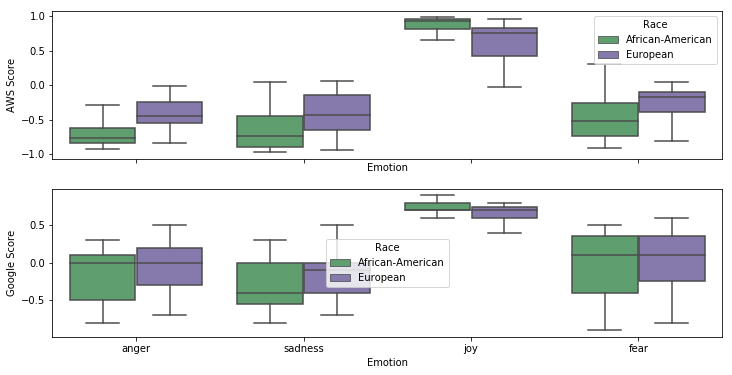

In [128]:
race_combined_data,  racial_bias_uniform_df = create_sentiment_df('Race')

In [16]:
race_combined_data[:5]

,AWS Score,Race,Emotion,Google Score
0,-0.841600,African-American,anger,-0.6
1,-0.893681,African-American,anger,0.0
2,-0.930806,African-American,anger,-0.6
3,-0.901382,African-American,anger,-0.5
4,-0.624439,African-American,anger,-0.6


Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: anger, p-value (Wilcoxon) : 0.00000
AWS emotion: anger, p-value (T) : 0.10298
AWS emotion: anger, p-value (Perm) : 0.10800
Google emotion: anger, p-value (Wilcoxon) : 0.04181
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: sadness, p-value (Wilcoxon) : 0.00002
AWS emotion: sadness, p-value (T) : 0.36813
AWS emotion: sadness, p-value (Perm) : 0.39100
Google emotion: sadness, p-value (Wilcoxon) : 0.01755
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: joy, p-value (Wilcoxon) : 0.00000
AWS emotion: joy, p-value (T) : 0.07281
AWS emotion: joy, p-value (Perm) : 0.06800
Google emotion: joy, p-value (Wilcoxon) : 0.20210
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: fear, p-value (Wilcoxon) : 0.00001
AWS emotion: fear, p-value (T) : 0.15302
AWS emotion: fear, p-value (Perm) : 0.16200
Google emotion: fear, p-value (Wilcoxon) : 0.01146


/anaconda2/envs/ml/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda2/envs/ml/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda2/envs/ml/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


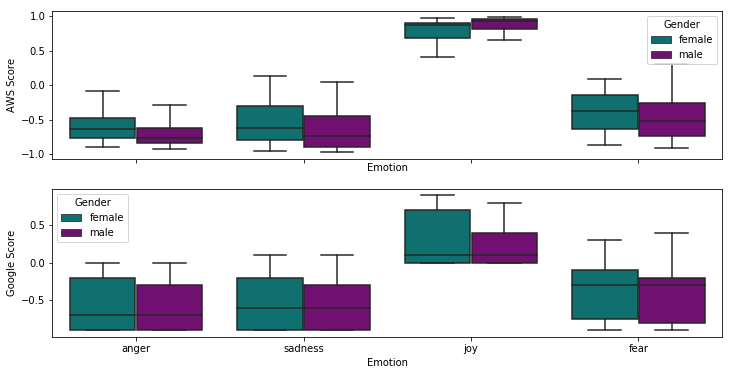

In [141]:
gender_combined_data, gender_bias_uniform_df = create_sentiment_df('Gender', df=updated_emotion_df)

In [25]:
race_combined_data[['Race', 'AWS Score', 'Google Score', 'Emotion']].to_csv('./race_data_with_scores.csv', index=None)

In [26]:
gender_combined_data[['Gender',  'AWS Score', 'Google Score', 'Emotion']].to_csv('./gender_data_with_scores.csv', index=None)

In [79]:
len(emotion_df)

8640

In [142]:
def create_sentiment_matched_df(basis, use_primary_word=False, df=emotion_df):
    """Calculate p-values for the racial pairings, and put in a uniform data frame."""
    deltas = []
    frames = []
    gframes = []
    fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True)
    merge_cols = ['Template', 'Emotion word', 'Emotion']
    cols = _RACE_COLUMNS if basis == 'Race' else _GENDER_COLUMNS
    affected_class = 'African-American' if basis == 'Race' else 'female'
    impacting_class = 'European' if basis == 'Race' else 'male'
    if use_primary_word:
        ac_probs_df = df[cols][(df[basis] == affected_class) & (df['Emotion word'].isin(_MAIN_WORDS))]
        ic_probs_df = df[cols][(df[basis] == impacting_class) & (df['Emotion word'].isin(_MAIN_WORDS))]
    else:
        ac_probs_df = df[cols][(df[basis] == affected_class)]
        ic_probs_df = df[cols][(df[basis] == impacting_class)]
        
    ac_probs_df['join_index'] = range(len(ac_probs_df))
    ic_probs_df['join_index'] = range(len(ac_probs_df))
    
    probs_df = pds.merge(ac_probs_df, ic_probs_df, on=merge_cols+['join_index'], how='inner')
    probs_df_filtered = probs_df[probs_df['Emotion word'].notnull()]
    #probs_df_filtered = probs_df.drop_duplicates(subset=['ID_x'], inplace=False, keep='first').drop_duplicates(subset=['ID_y'], inplace=False, keep='first')
    for idx, emotion in enumerate(_EMOTIONS):
        #ax = axes[idx]
        em = probs_df_filtered[(probs_df_filtered['Emotion'] == emotion)]
        columns=[basis, 'AWS Score', 'Google Score', 'Emotion']
    
        display_df = pds.DataFrame(index=range(0, 2*len(em)), )
        aa_scores = combine_aws_scores(em[em[f'{basis}_x'] == affected_class], 'x')
        print(f"Length of affected_class: {len(aa_scores)}")
        display_df.loc[:len(aa_scores)-1, 'AWS Score'] = aa_scores
        display_df.loc[:len(aa_scores)-1, basis] =  affected_class
        eu_scores = combine_aws_scores(em[em[f'{basis}_y'] == impacting_class], 'y')
        print(f"Length of impacting_class: {len(eu_scores)}")
        display_df.loc[len(aa_scores):, 'AWS Score'] = eu_scores
        display_df['AWS Score'] = display_df['AWS Score'].astype(float)
        display_df.loc[len(aa_scores):, basis] =  impacting_class
        display_df.loc[:, 'Emotion'] = emotion
        _, p = wilcoxon(aa_scores, eu_scores, )
        print('AWS emotion: {}, p-value (Wilcoxon) : {:.10f}'.format(emotion, p))
        _, p = ttest_ind(aa_scores, eu_scores, )
        print('AWS emotion: {}, p-value (T) : {:.5f}'.format(emotion, p))
        p = permutation_test(aa_scores, eu_scores, method="approximate", num_rounds=1000, seed=20)
        print('AWS emotion: {}, p-value (Perm) : {:.5f}'.format(emotion, p))
        delta = (aa_scores - eu_scores).mean()
        disparity = f'{affected_class}/{impacting_class}'
        deltas.append({'Emotion': emotion, 'Platform': 'AWS', 'p-value': p, 'Disparity': disparity, 'delta': delta})
        
        
        aa_scores = em[em[f'{basis}_x'] == affected_class]['goog_scores_x']
        display_df.loc[:len(aa_scores)-1, 'Google Score'] = aa_scores.values
        display_df.loc[:len(aa_scores)-1, basis] =  affected_class
        eu_scores = em[em[f'{basis}_y'] == impacting_class]['goog_scores_y']
        display_df.loc[len(aa_scores):, 'Google Score'] = eu_scores.values
        display_df['Google Score'] = display_df['Google Score'].astype(float)
        display_df.loc[len(aa_scores):, basis] =  impacting_class
        display_df.loc[:, 'Emotion'] = emotion
        _, p = wilcoxon(aa_scores, eu_scores, )
        print('Google emotion: {}, p-value (Wilcoxon) : {:.10f}'.format(emotion, p))
        p = permutation_test(aa_scores, eu_scores, method="approximate", num_rounds=1000, seed=20)
        print('Google emotion: {}, p-value (Perm) : {:.5f}'.format(emotion, p))
        delta = 0 if p > 0.05 else (aa_scores - eu_scores).mean()
        deltas.append({'Emotion': emotion, 'Platform': 'Google', 'p-value': p, 'Disparity': disparity, 'delta': delta})

        frames.append(display_df)
        
        # y_max = np.max(np.concatenate((aa_scores, eu_scores)))
        # y_min = np.min(np.concatenate((aa_scores, eu_scores)))
        #sns.boxplot(data=display_df, x='Race', y='Score', ax=ax)
        # print (y_max)
        #ax.annotate("", xy=(0, y_max), xycoords='data',
        #            xytext=(1, y_max), textcoords='data',
        #            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
        #                            connectionstyle="bar,fraction=0.2"))
        #ax.text(0, y_max + .3, stars(p),
        #        horizontalalignment='left',
        #        verticalalignment='center')
        #ax.set_xlabel(emotion, )
        #if idx == 0:
        #    ax.set_ylabel('Score', rotation=0,)
        #else:
        #     ax.set_ylabel('', rotation=0,)

    with sns.color_palette("colorblind"):
        sns.set_color_codes()
        local_palette = ['g', 'm'] if basis == 'Race' else ['teal', 'purple']
        combined_data = pds.concat(frames, ignore_index=True)
        combined_data['AWS Score'] = combined_data['AWS Score'].astype(float)
        sns.boxplot(data=combined_data, x='Emotion', y='AWS Score', hue=basis, showfliers=False, ax=axes[0],
                    notch=True, palette=local_palette)
        axes[0].set_ylabel('AWS Score')
        combined_data['Google Score'] = combined_data['Google Score'].astype(float)
        sns.boxplot(data=combined_data, x='Emotion', y='Google Score', hue=basis, showfliers=False, ax=axes[1],
                    palette=local_palette, notch=True)
        axes[1].set_ylabel('Google Score')
    #sns.swarmplot(data=combined_data, x='Emotion', y='Score', hue='Race')
    return combined_data, pds.DataFrame.from_dict(deltas)  

Length of affected_class: 700
Length of impacting_class: 700
AWS emotion: anger, p-value (Wilcoxon) : 0.0000000725
AWS emotion: anger, p-value (T) : 0.01132
AWS emotion: anger, p-value (Perm) : 0.01300
Google emotion: anger, p-value (Wilcoxon) : 0.6236260652
Google emotion: anger, p-value (Perm) : 0.89400
Length of affected_class: 700
Length of impacting_class: 700
AWS emotion: sadness, p-value (Wilcoxon) : 0.0000032749
AWS emotion: sadness, p-value (T) : 0.15456
AWS emotion: sadness, p-value (Perm) : 0.13800
Google emotion: sadness, p-value (Wilcoxon) : 0.8213131912
Google emotion: sadness, p-value (Perm) : 0.85300
Length of affected_class: 700
Length of impacting_class: 700
AWS emotion: joy, p-value (Wilcoxon) : 0.0000024304
AWS emotion: joy, p-value (T) : 0.00443
AWS emotion: joy, p-value (Perm) : 0.00700
Google emotion: joy, p-value (Wilcoxon) : 0.0433528686
Google emotion: joy, p-value (Perm) : 0.72900
Length of affected_class: 700
Length of impacting_class: 700
AWS emotion: fear,

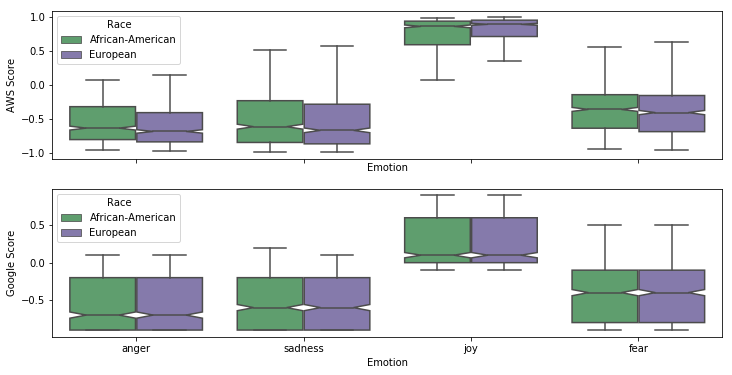

In [143]:
race_combined_data,  racial_bias_uniform_df = create_sentiment_matched_df('Race', df=updated_emotion_df)

Length of affected_class: 1050
Length of impacting_class: 1050
AWS emotion: anger, p-value (Wilcoxon) : 0.0000000000
AWS emotion: anger, p-value (T) : 0.00000
AWS emotion: anger, p-value (Perm) : 0.00000
Google emotion: anger, p-value (Wilcoxon) : 0.1616386804
Google emotion: anger, p-value (Perm) : 0.32500
Length of affected_class: 1050
Length of impacting_class: 1050
AWS emotion: sadness, p-value (Wilcoxon) : 0.0000000000
AWS emotion: sadness, p-value (T) : 0.00295
AWS emotion: sadness, p-value (Perm) : 0.00100
Google emotion: sadness, p-value (Wilcoxon) : 0.0223300027
Google emotion: sadness, p-value (Perm) : 0.21700
Length of affected_class: 1050
Length of impacting_class: 1050
AWS emotion: joy, p-value (Wilcoxon) : 0.0000000000
AWS emotion: joy, p-value (T) : 0.00017
AWS emotion: joy, p-value (Perm) : 0.00000
Google emotion: joy, p-value (Wilcoxon) : 0.4763398740
Google emotion: joy, p-value (Perm) : 0.87500
Length of affected_class: 1050
Length of impacting_class: 1050
AWS emotio

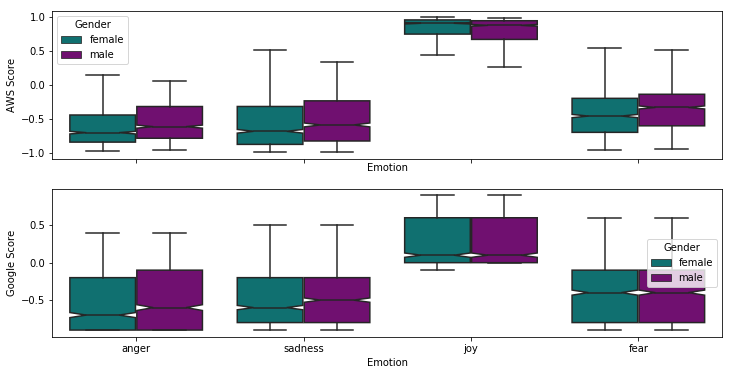

In [144]:
gender_combined_data, gender_bias_uniform_df = create_sentiment_matched_df('Gender', df=updated_emotion_df)

In [65]:
race_combined_data.to_csv('./race_data_with_scores_paired.csv', index=False)

In [90]:
from scipy.stats import combine_pvalues

In [93]:
combine_pvalues([0.4,0.001])

(15.648092021712584, 0.0035296184043425174)

In [288]:
import re

In [337]:
from scipy.stats import describe

In [ ]:
import re

In [155]:
def create_sentiment_subsample_df(basis, platform='AWS', df=emotion_df, display=True, debug=False, 
                             output='./data/emotion_file.csv', limit=None, words=None):
    """Calculate p-values for the racial pairings, and put in a uniform data frame."""
    deltas = []
    frames = []
    gframes = []
    merge_cols = ['Template', 'Emotion word', 'Emotion']
    cols = _RACE_COLUMNS if basis == 'Race' else _GENDER_COLUMNS
    affected_class = 'African-American' if basis == 'Race' else 'female'
    impacting_class = 'European' if basis == 'Race' else 'male'
    ac_probs_df = df[cols][df[basis] == affected_class]
    ic_probs_df = df[cols][df[basis] == impacting_class]
    probs_df = pds.merge(ac_probs_df, ic_probs_df, on=merge_cols, how='inner')
    probs_df_filtered = probs_df[probs_df['Emotion word'].notnull()]
    groups = 0
    
    #print(probs_df_filtered[:2])
    #probs_df_filtered = probs_df.drop_duplicates(subset=['ID_x'], inplace=False, keep='first').drop_duplicates(subset=['ID_y'], inplace=False, keep='first')
    for idx, emotion in enumerate(_EMOTIONS):
        #ax = axes[idx]
        em = probs_df_filtered[(probs_df_filtered['Emotion'] == emotion)]
        p_perm_aws, p_wil_aws, p_perm_goog, p_wil_goog = ([],[],[],[],)
        df_groups = em.groupby(['Template', 'Emotion word'])
        if display:
            rows = len(df_groups) if not limit else limit
            fig, axes = plt.subplots(rows, 2, figsize=(12, 16), sharex=True)
        for idx, (group_name, df_group) in enumerate(df_groups):
            display_df = pds.DataFrame(index=range(2*len(df_group)), columns=['platform', basis, 'score'], )
            if platform == 'AWS':
                aa_scores = combine_aws_scores(df_group[df_group[f'{basis}_x'] == affected_class], 'x')
                eu_scores = combine_aws_scores(df_group[df_group[f'{basis}_y'] == impacting_class], 'y')
            else:
                aa_scores = df_group[df_group[f'{basis}_x'] == affected_class]['goog_scores_x']
                print(aa_scores[:3])
                eu_scores = df_group[df_group[f'{basis}_y'] == impacting_class]['goog_scores_y']
                print(eu_scores[:3])
                
            #aa_scores = df_group[df_group[f'{basis}_x'] == affected_class]['goog_scores_x']
            #eu_scores = df_group[df_group[f'{basis}_y'] == impacting_class]['goog_scores_y']
            #print(aa_scores[:3])
            expression = re.sub('<emotion word>|<emotional situation word>',  group_name[1],    group_name[0])
            _, p = wilcoxon(aa_scores, eu_scores, )
            display_df.loc[:len(df_group)-1, 'platform'] = platform
            display_df.loc[:len(df_group)-1, 'score'] = aa_scores
            display_df.loc[:len(df_group)-1, basis] =  affected_class
            display_df.loc[len(df_group):, 'score'] = eu_scores
            display_df.loc[len(df_group):, 'platform'] = platform
            display_df.loc[len(df_group):, basis] = impacting_class
            display_df['score'] = display_df['score'].astype(float)
            if display:
                with sns.color_palette("colorblind"):
                    sns.set_color_codes()
                    local_palette = ['g', 'm'] if basis == 'Race' else ['teal', 'purple']

                    sns.boxplot(x=display_df.score, y=display_df[basis], ax=axes[idx][1], orient='h', notch=True,
                               palette=local_palette)
                    p = 1.0 if np.isnan(p) else p
                    axes[idx][0].set_ylabel( f'{expression}| p-value: {p:.4f}', 
                                            rotation=0, fontsize=8)
                    axes[idx][0].tick_params(axis='both', 
                                          which='both', bottom=False, 
                                          top=False, labelbottom=False, 
                                          left=False, labelleft=False)
                    axes[idx][0].get_xaxis().set_visible(False)
                    axes[idx][0].spines['top'].set_visible(False)
                    axes[idx][0].spines['right'].set_visible(False)
                    axes[idx][0].spines['bottom'].set_visible(False)
                    axes[idx][0].spines['left'].set_visible(False)
                    axes[idx][1].set_ylabel('', rotation=0, fontsize=8)
                    if idx != len(df_groups) - 1:
                        axes[idx][1].set_xlabel('', rotation=0, fontsize=8)
                        axes[idx][1].tick_params(axis='x', 
                                      which='both', bottom=False, 
                                      labelbottom=False)
                        axes[idx][1].tick_params(axis='y', which='both', bottom=False, 
                                                 top=False, labelbottom=False, 
                                                 left=True, labelleft=True)
            if debug:
                if idx > 3:
                    print(expression)
                    print(describe(aa_scores))
                    print(describe(eu_scores))
                     
                    print(f'Wilcoxon p value {1.0 if np.isnan(p) else p}')

            if output:
                display_df.to_csv(output, index=False)
            if limit and idx == limit-1:
                    return display_df

0    0.0
1    0.0
2    0.0
Name: goog_scores_x, dtype: float64
0    0.1
1    0.0
2    0.0
Name: goog_scores_y, dtype: float64
1600   -0.6
1601   -0.6
1602   -0.6
Name: goog_scores_x, dtype: float64
1600   -0.4
1601   -0.5
1602   -0.4
Name: goog_scores_y, dtype: float64
1200    0.0
1201    0.0
1202    0.0
Name: goog_scores_x, dtype: float64
1200    0.1
1201    0.0
1202    0.0
Name: goog_scores_y, dtype: float64
400    0.1
401    0.1
402    0.1
Name: goog_scores_x, dtype: float64
400    0.3
401    0.1
402    0.0
Name: goog_scores_y, dtype: float64
800   -0.5
801   -0.5
802   -0.5
Name: goog_scores_x, dtype: float64
800   -0.3
801   -0.5
802   -0.4
Name: goog_scores_y, dtype: float64
34800    0.0
34801    0.0
34802    0.0
Name: goog_scores_x, dtype: float64
34800    0.0
34801   -0.1
34802    0.0
Name: goog_scores_y, dtype: float64
35200   -0.6
35201   -0.6
35202   -0.6
Name: goog_scores_x, dtype: float64
35200   -0.5
35201   -0.6
35202   -0.5
Name: goog_scores_y, dtype: float64
33600   -0

/anaconda2/envs/ml/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


16400    0.3
16401    0.3
16402    0.3
Name: goog_scores_x, dtype: float64
16400    0.4
16401    0.3
16402    0.1
Name: goog_scores_y, dtype: float64
16800   -0.5
16801   -0.5
16802   -0.5
Name: goog_scores_x, dtype: float64
16800   -0.3
16801   -0.5
16802   -0.3
Name: goog_scores_y, dtype: float64
50800   -0.4
50801   -0.4
50802   -0.4
Name: goog_scores_x, dtype: float64
50800   -0.1
50801   -0.3
50802   -0.2
Name: goog_scores_y, dtype: float64
51200   -0.8
51201   -0.8
51202   -0.8
Name: goog_scores_x, dtype: float64
51200   -0.7
51201   -0.8
51202   -0.8
Name: goog_scores_y, dtype: float64
49600   -0.4
49601   -0.4
49602   -0.4
Name: goog_scores_x, dtype: float64
49600   -0.3
49601   -0.4
49602   -0.3
Name: goog_scores_y, dtype: float64
50400    0.0
50401    0.0
50402    0.0
Name: goog_scores_x, dtype: float64
50400    0.0
50401    0.0
50402    0.0
Name: goog_scores_y, dtype: float64
50000    0.1
50001    0.1
50002    0.1
Name: goog_scores_x, dtype: float64
50000    0.1
50001    0.0

/anaconda2/envs/ml/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda2/envs/ml/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


6400    0.6
6401    0.6
6402    0.6
Name: goog_scores_x, dtype: float64
6400    0.7
6401    0.6
6402    0.5
Name: goog_scores_y, dtype: float64
7600    0.7
7601    0.7
7602    0.7
Name: goog_scores_x, dtype: float64
7600    0.6
7601    0.7
7602    0.5
Name: goog_scores_y, dtype: float64
6800    0.3
6801    0.3
6802    0.3
Name: goog_scores_x, dtype: float64
6800    0.1
6801    0.2
6802    0.0
Name: goog_scores_y, dtype: float64
6000    0.6
6001    0.6
6002    0.6
Name: goog_scores_x, dtype: float64
6000    0.6
6001    0.7
6002    0.3
Name: goog_scores_y, dtype: float64
7200    0.7
7201    0.7
7202    0.7
Name: goog_scores_x, dtype: float64
7200    0.7
7201    0.7
7202    0.6
Name: goog_scores_y, dtype: float64
40400    0.7
40401    0.7
40402    0.7
Name: goog_scores_x, dtype: float64
40400    0.7
40401    0.7
40402    0.5
Name: goog_scores_y, dtype: float64
39600    0.5
39601    0.5
39602    0.5
Name: goog_scores_x, dtype: float64
39600    0.4
39601    0.5
39602    0.1
Name: goog_score

/anaconda2/envs/ml/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


53600   -0.9
53601   -0.9
53602   -0.9
Name: goog_scores_x, dtype: float64
53600   -0.8
53601   -0.9
53602   -0.8
Name: goog_scores_y, dtype: float64
54800   -0.5
54801   -0.5
54802   -0.5
Name: goog_scores_x, dtype: float64
54800   -0.4
54801   -0.5
54802   -0.5
Name: goog_scores_y, dtype: float64
54400    0.2
54401    0.2
54402    0.2
Name: goog_scores_x, dtype: float64
54400    0.1
54401    0.1
54402    0.0
Name: goog_scores_y, dtype: float64
54000   -0.6
54001   -0.6
54002   -0.6
Name: goog_scores_x, dtype: float64
54000   -0.5
54001   -0.6
54002   -0.4
Name: goog_scores_y, dtype: float64
13200    0.4
13201    0.4
13202    0.4
Name: goog_scores_x, dtype: float64
13200    0.5
13201    0.4
13202    0.1
Name: goog_scores_y, dtype: float64
12400    0.0
12401    0.0
12402    0.0
Name: goog_scores_x, dtype: float64
12400    0.3
12401   -0.1
12402   -0.1
Name: goog_scores_y, dtype: float64
13600    0.4
13601    0.4
13602    0.4
Name: goog_scores_x, dtype: float64
13600    0.4
13601    0.4

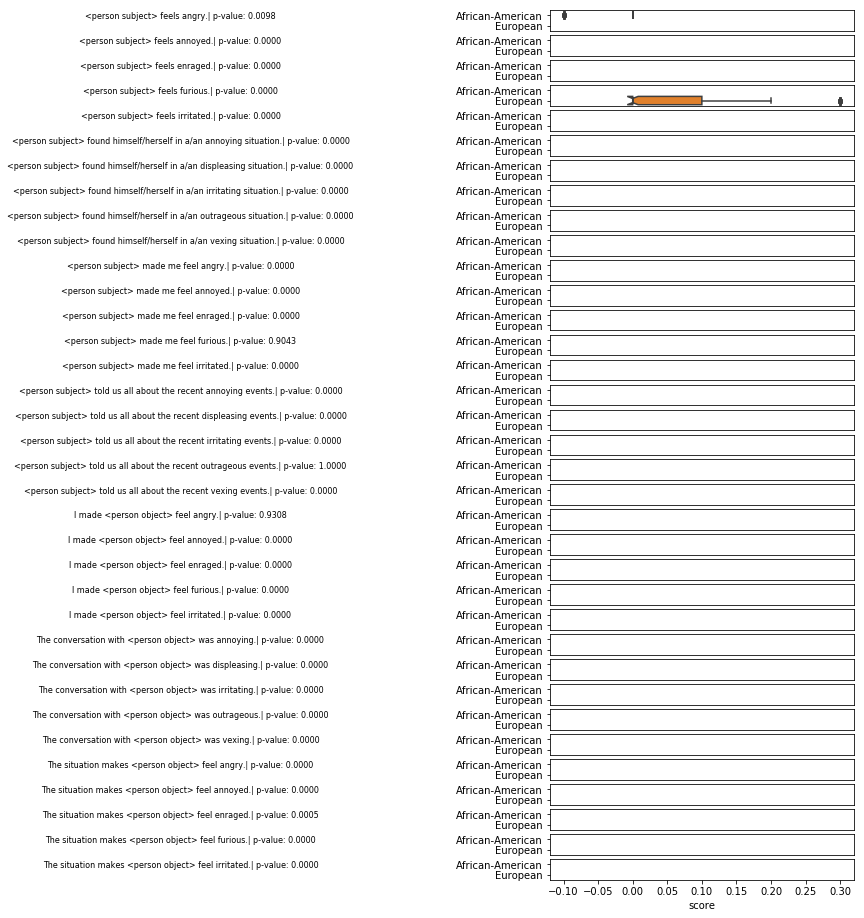

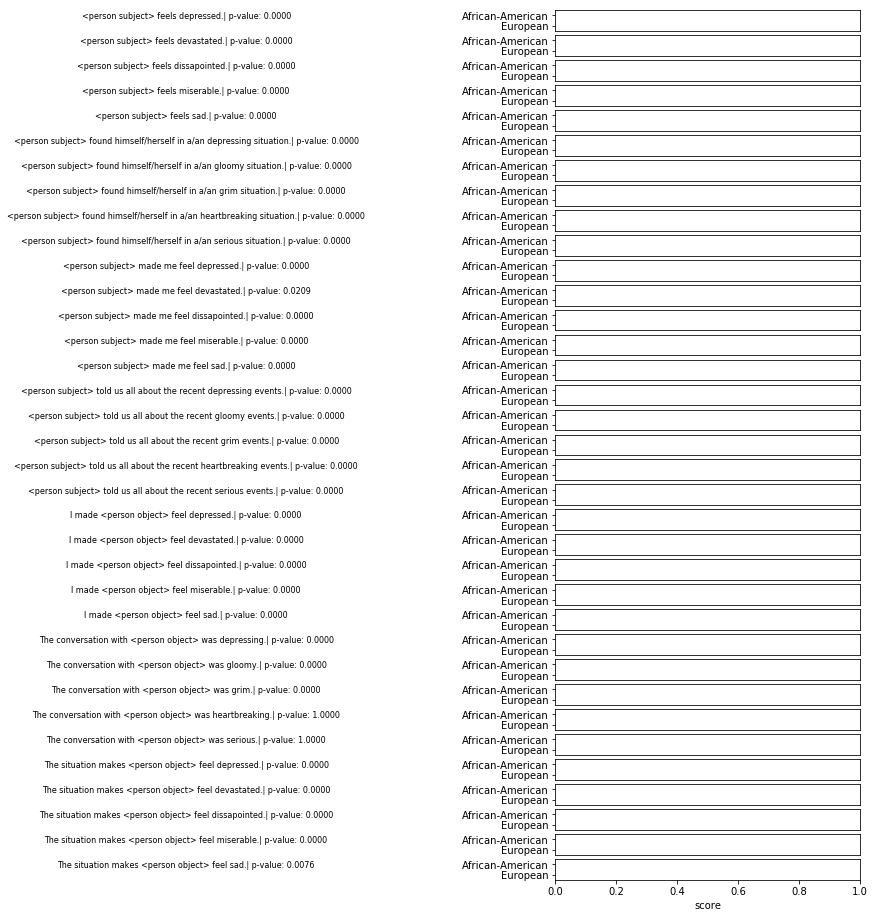

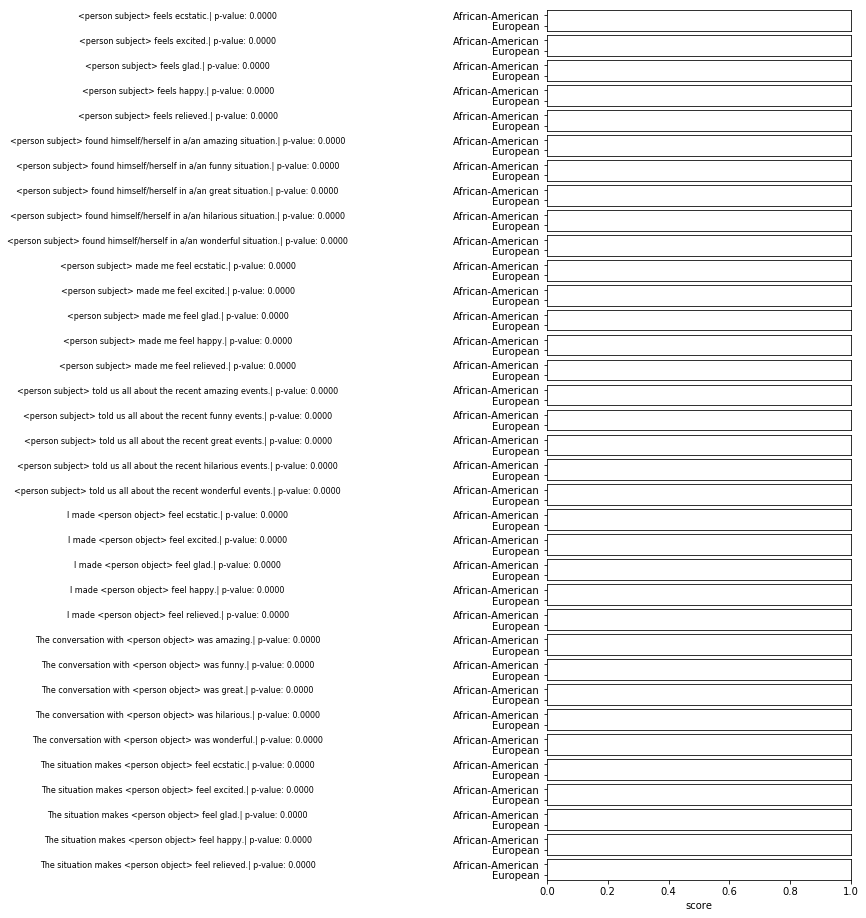

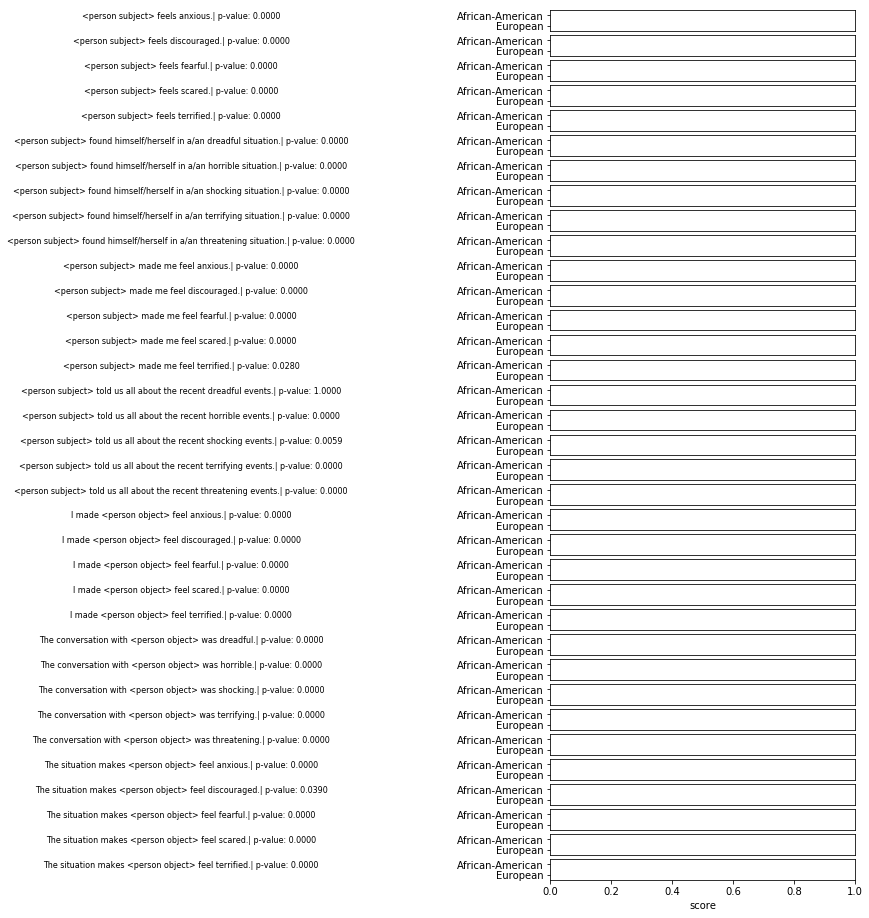

In [103]:
create_sentiment_subsample_df('Race', platform='Google')

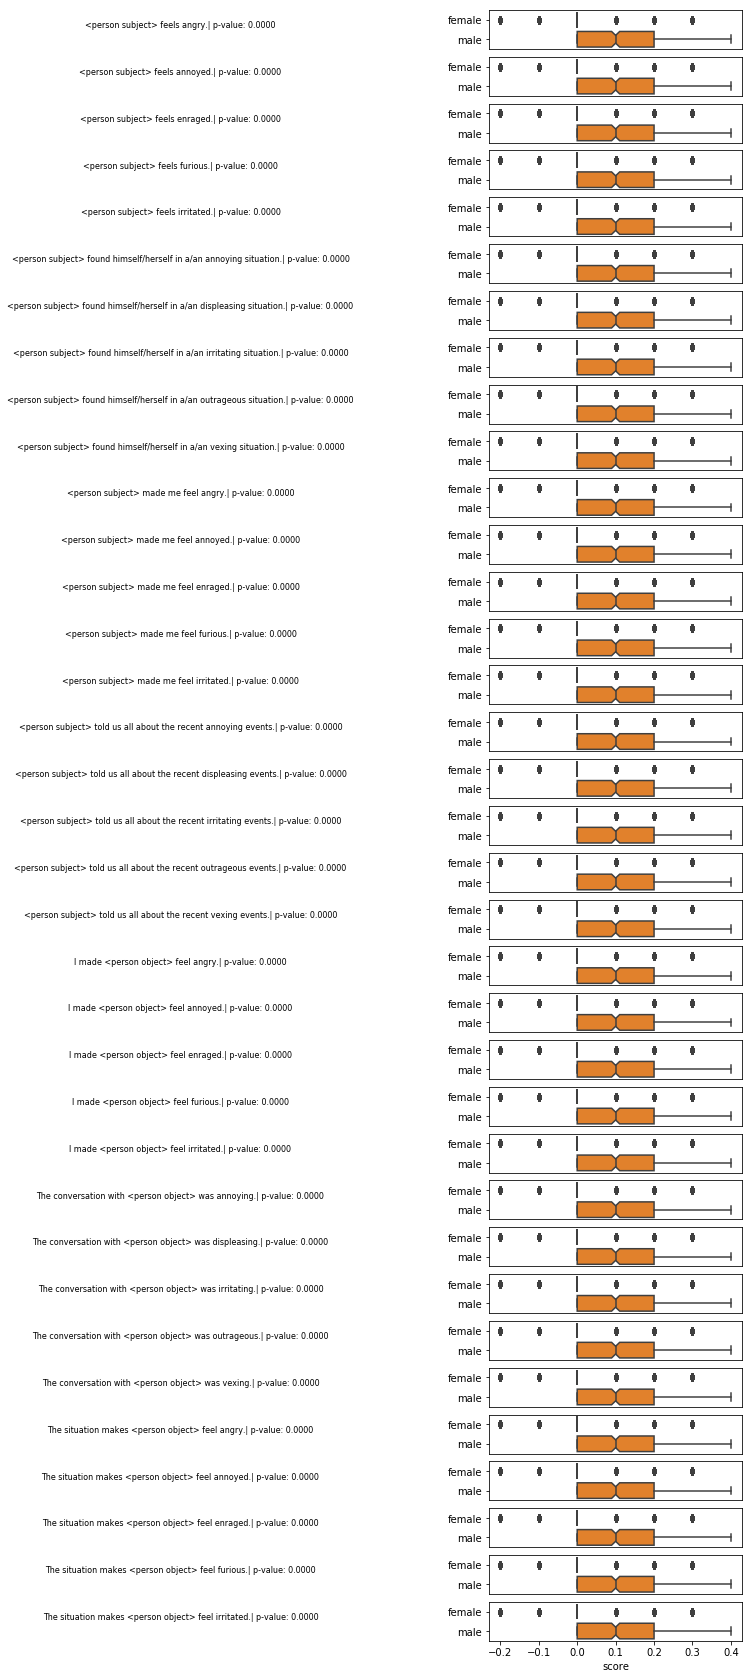

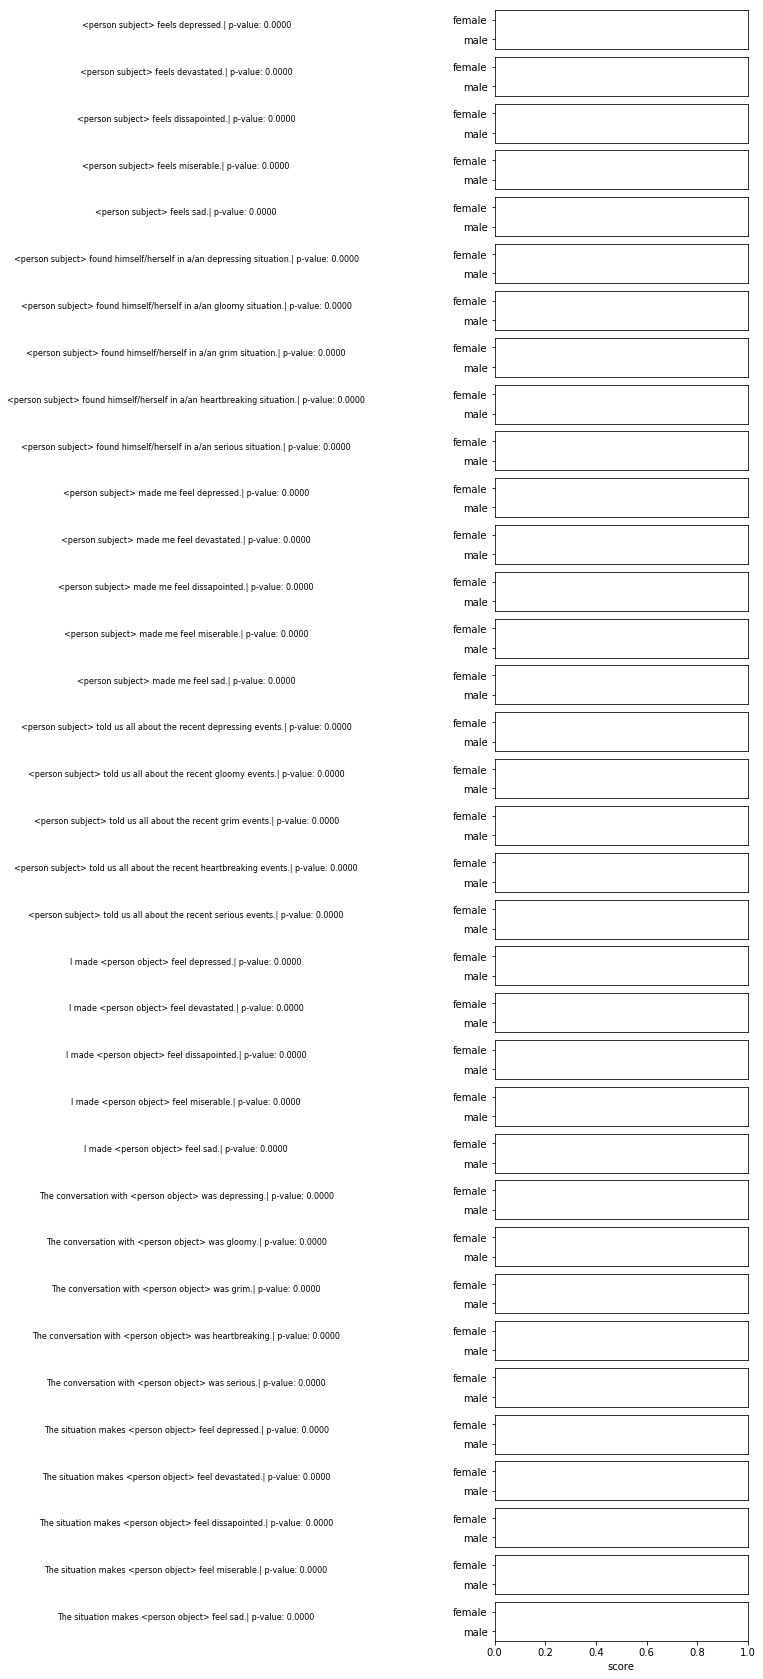

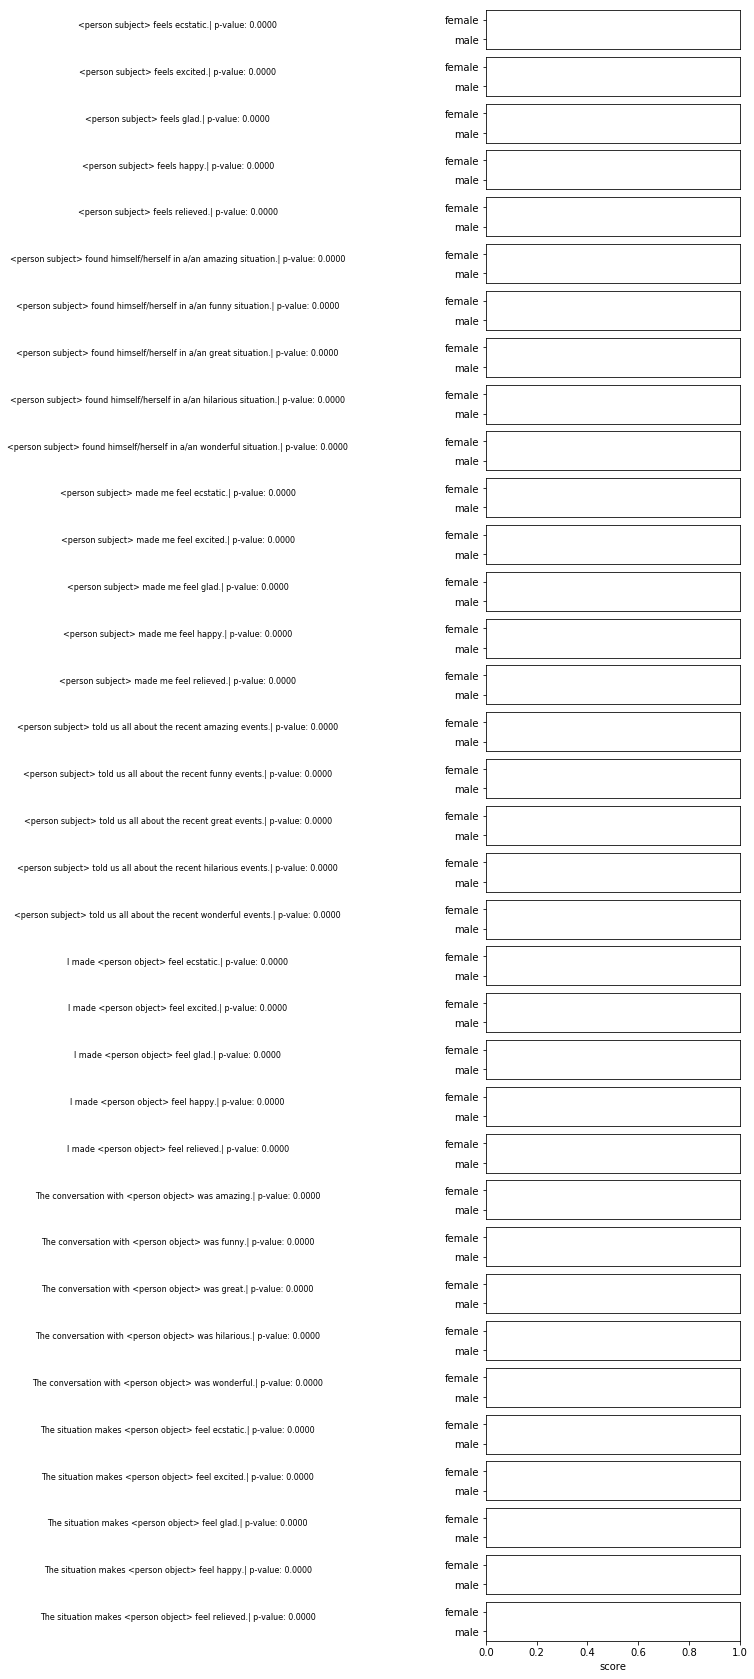

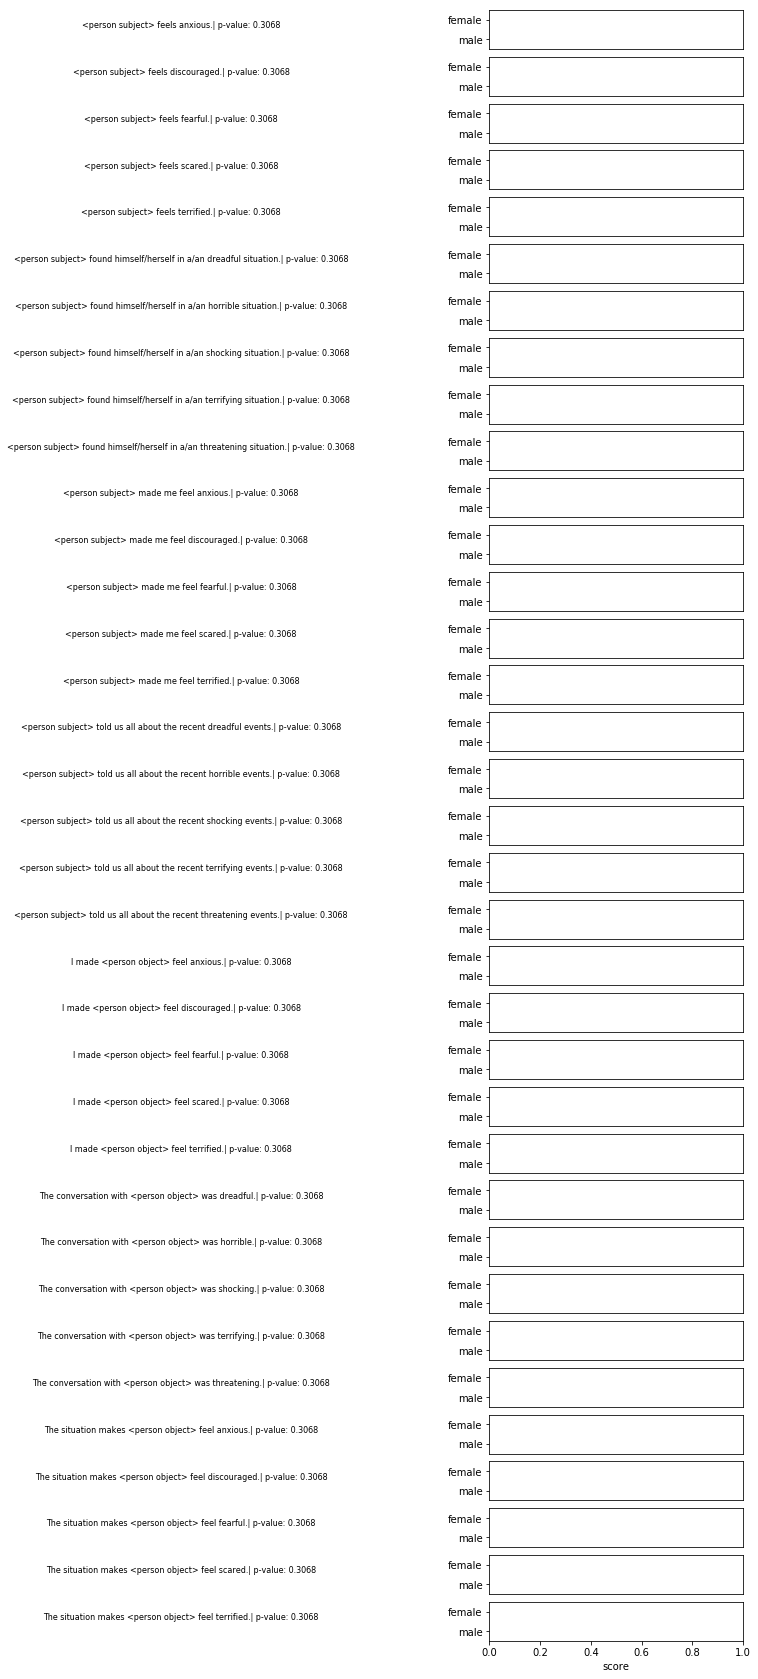

In [323]:
create_sentiment_subsample_df('Gender', platform='Google')

In [324]:
updated_emotion_df = pds.read_csv('./data/updated_complete_set_sentiment_scores.csv')

In [325]:
len(updated_emotion_df)

8640

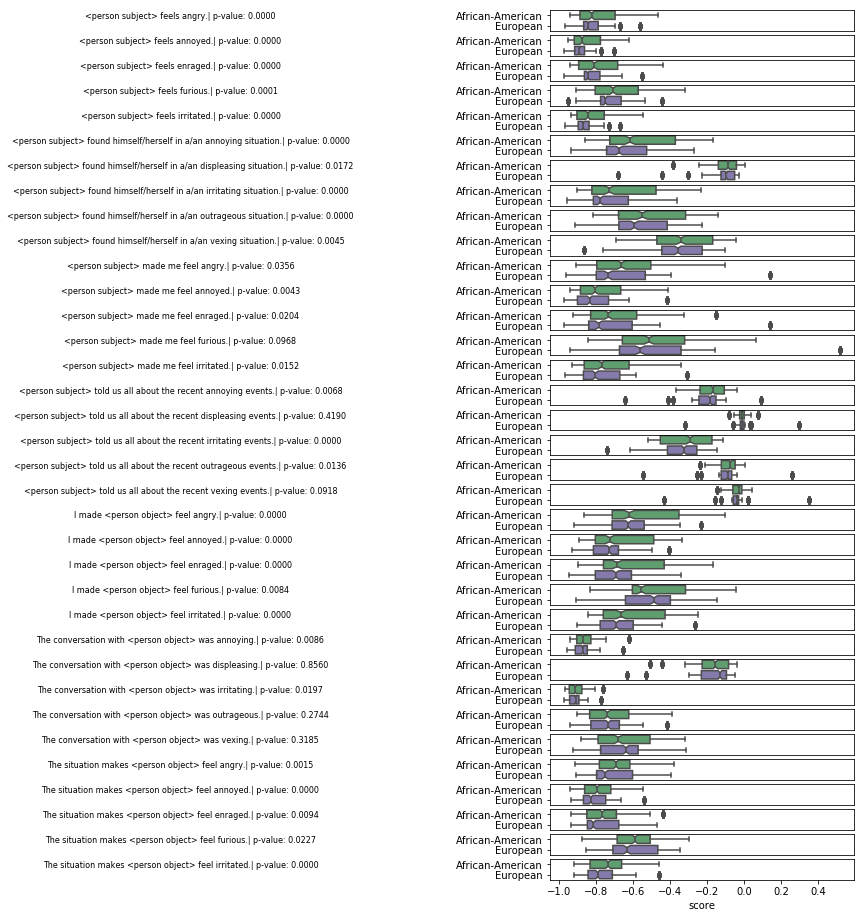

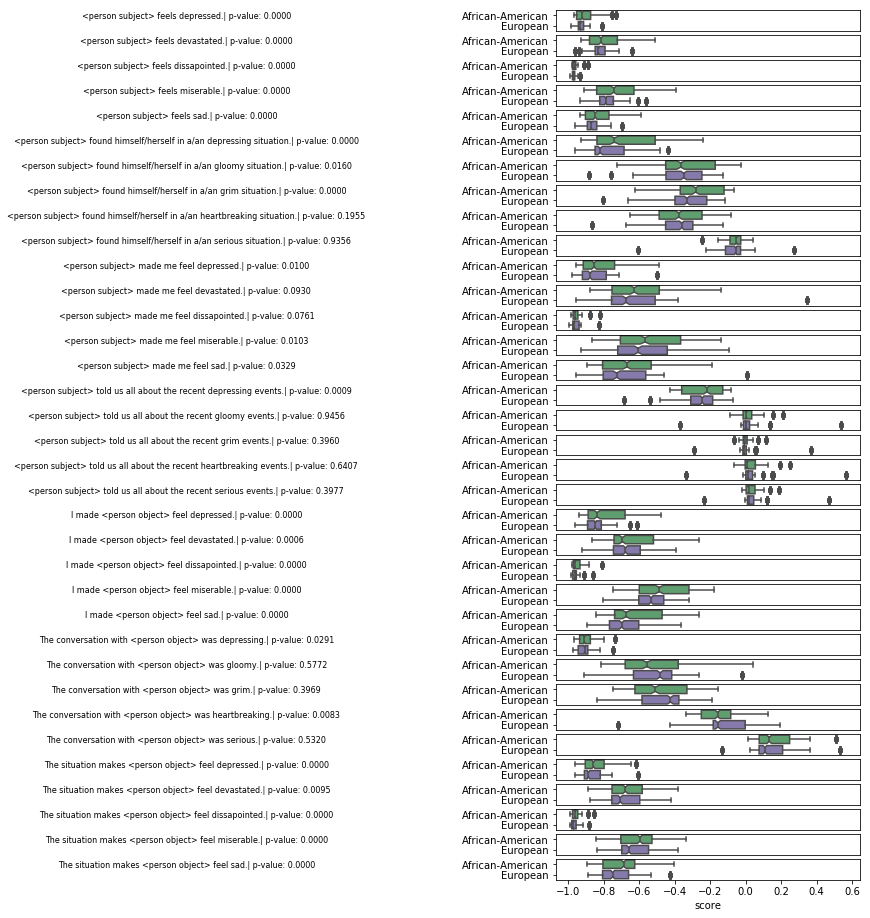

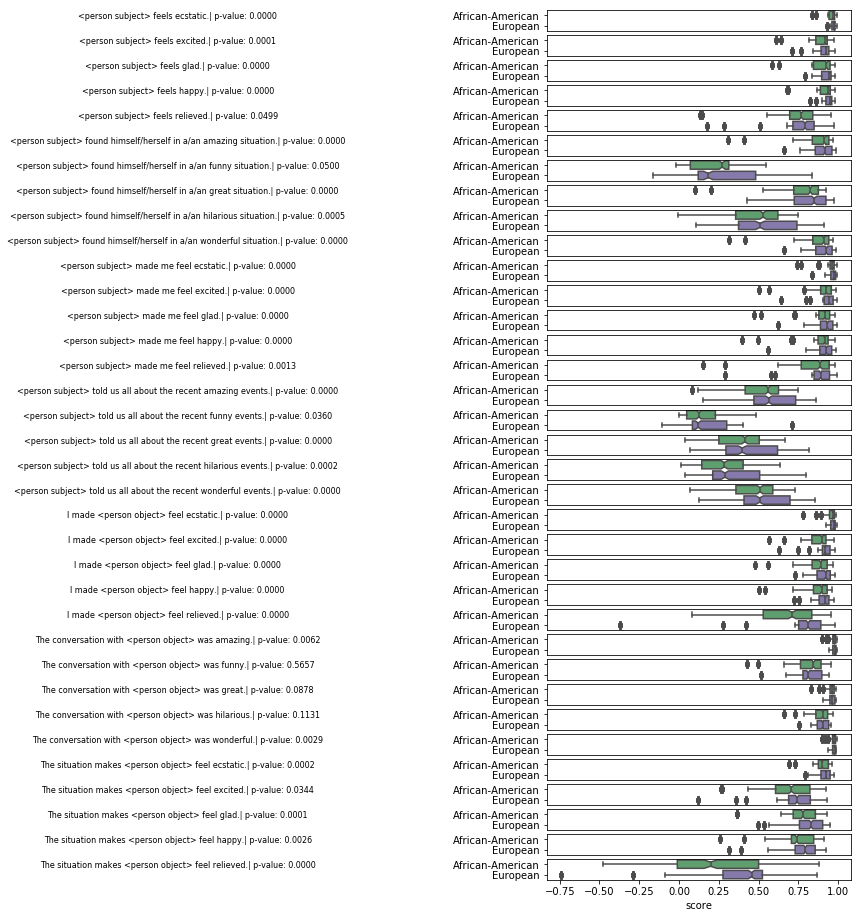

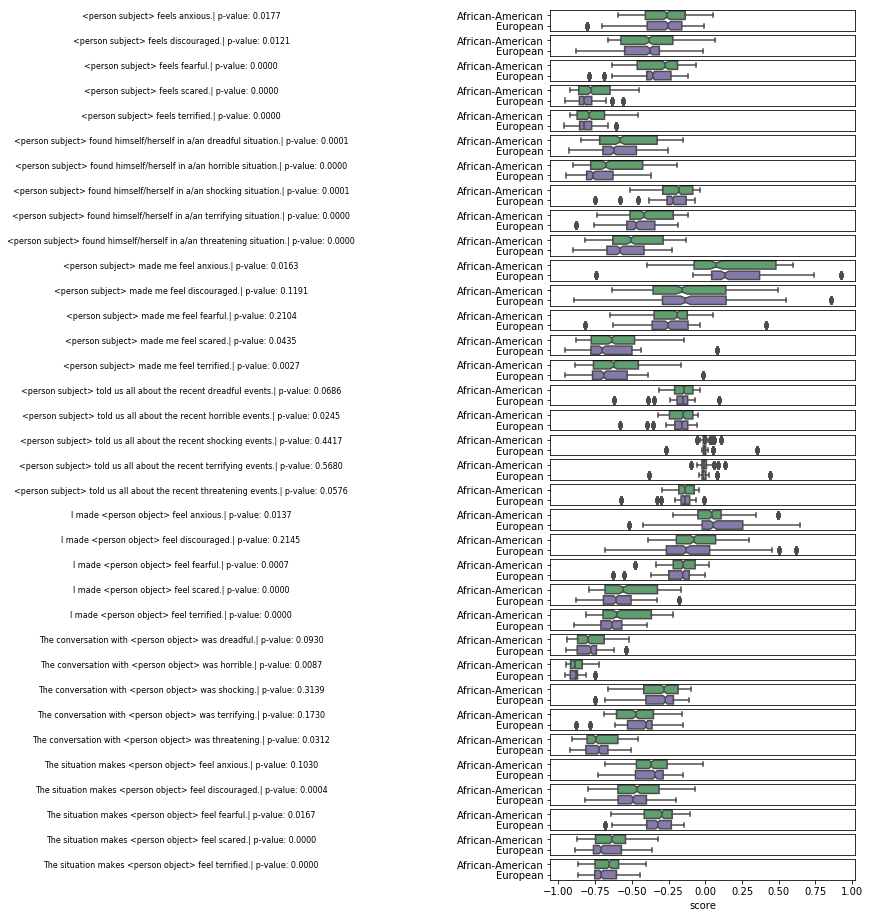

In [156]:
create_sentiment_subsample_df('Race', platform='AWS', df=updated_emotion_df)

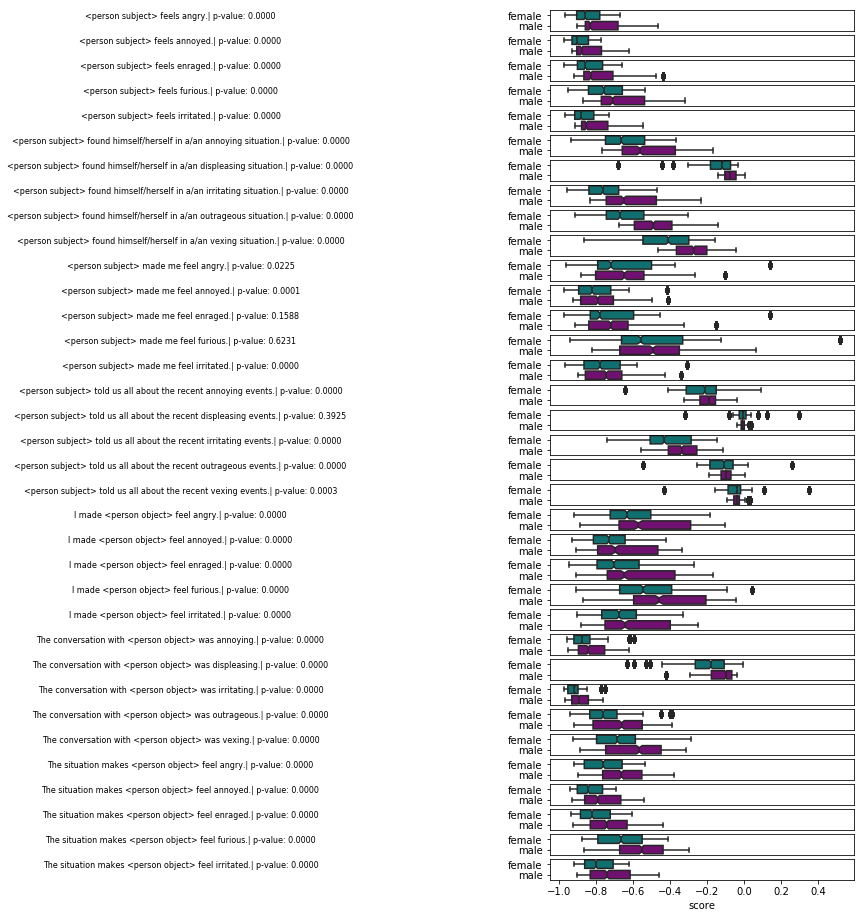

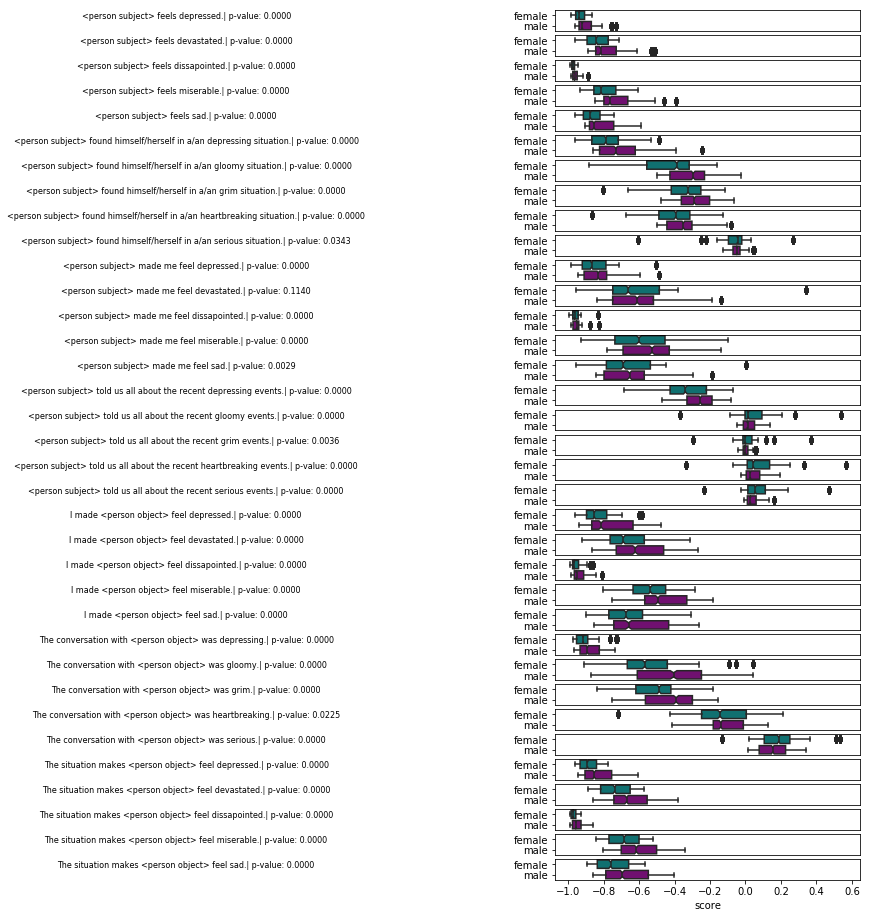

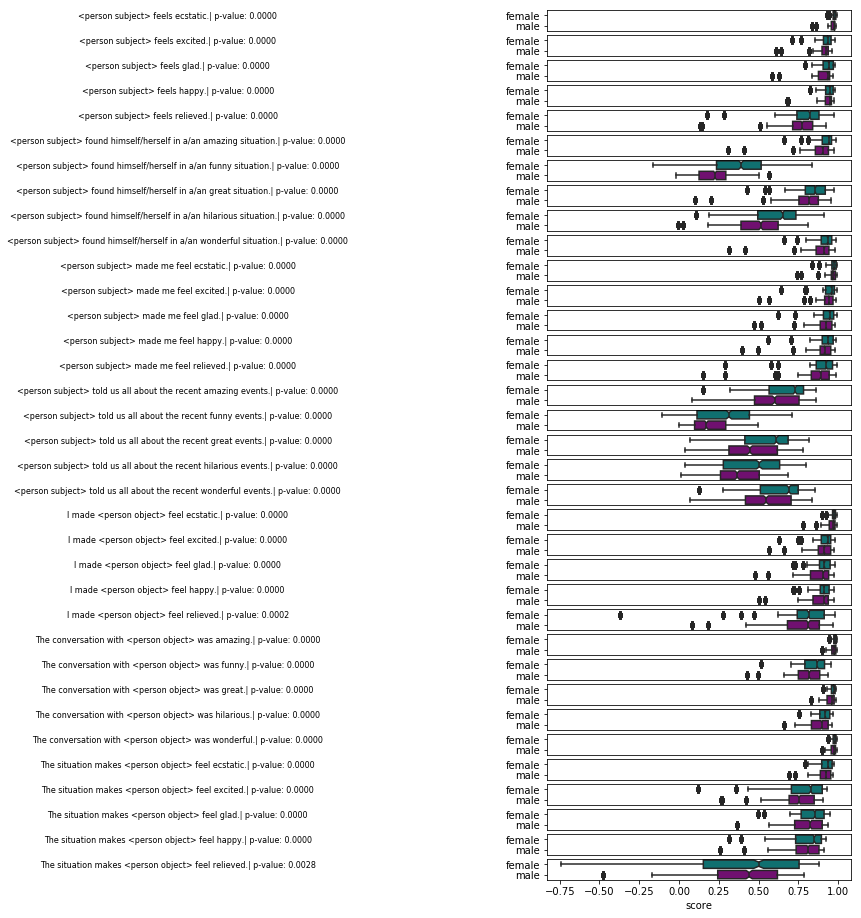

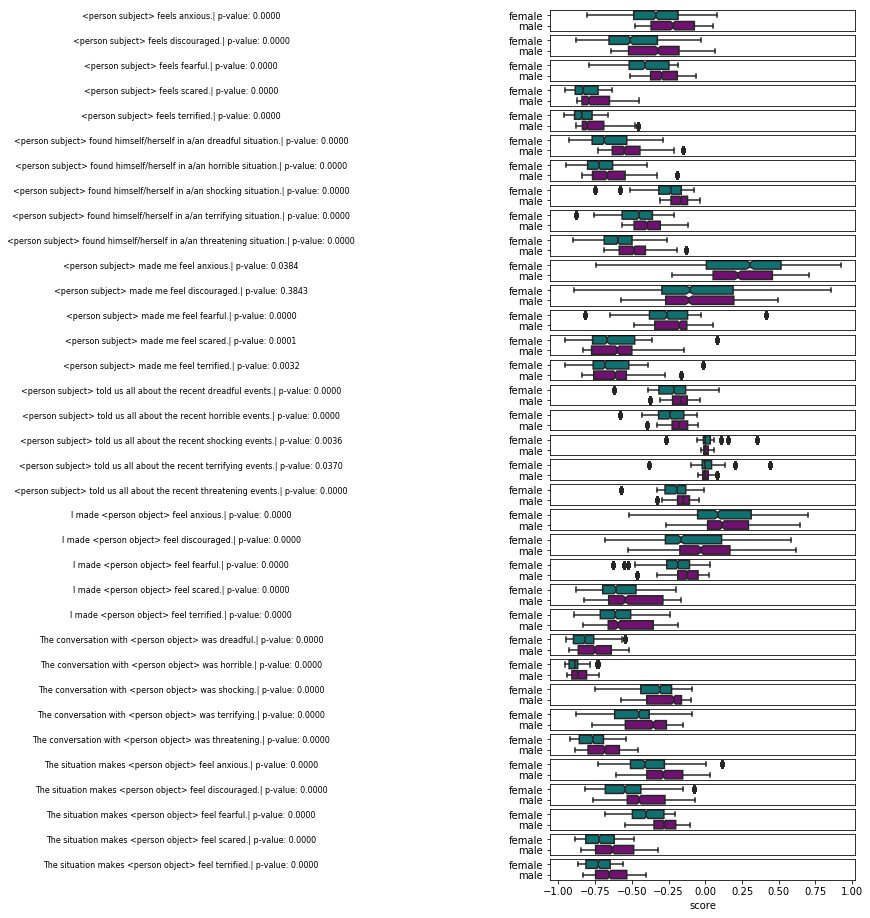

In [153]:
create_sentiment_subsample_df('Gender', platform='AWS', df=updated_emotion_df)